In [106]:
import numpy as np
import pandas as pd
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from glob import glob
import os, sys
from keras.preprocessing.image import load_img
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Flatten, Convolution2D
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
from IPython.display import FileLink

In [84]:
def limit_mem():
    K.get_session().close() #new line lets you reset GPU memory without closing notebook
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [85]:
DATA_PATH = '/home/bfortuner/workplace/data/fisheries/'
TRAIN_PATH = DATA_PATH+'train/'
VALID_PATH = DATA_PATH+'valid/'
TEST_PATH = DATA_PATH+'test/'
WEIGHTS_PATH = DATA_PATH+'weights/'
RESULTS_PATH = DATA_PATH+'results/'
SAMPLE_PATH = DATA_PATH+'sample/'

In [27]:
%mkdir $VALID_PATH
%mkdir $WEIGHTS_PATH
%mkdir $RESULTS_PATH
%mkdir $SAMPLE_PATH

In [86]:
#Sample Submission File
'''
image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00005.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733
img_00007.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733
'''

'\nimage,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\nimg_00005.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733\nimg_00007.jpg,0.45500264690312336,0.05293806246691371,0.03096876654314452,0.017734250926416093,0.12308099523557438,0.07914240338803599,0.046585494970884066,0.1942826892535733\n'

### Create Validation Set

3777 training images
1000 test images
Anywhere from 200-1000 images per category
Let's use a validation set of about 20%? or ~755 images

In [30]:
#Create subdirectories in valid/
%cd $TRAIN_PATH
for d in glob('*'):
    os.mkdir(VALID_PATH+d)

/home/bfortuner/workplace/data/fisheries/train


In [31]:
# Move validation images from train/ to valid/
VALIDATION_SET_SIZE = 755
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(VALIDATION_SET_SIZE): 
    os.rename(shuf[i], VALID_PATH + shuf[i])

### Explore Images

1. Images are not evenly distributed. Sharks has >200 while ALB has > 1000
2. Image dimensions are around 1280 (width) by 750 (height)   -- BIG!

In [87]:
def get_paths_to_files(dir_path):
    filepaths = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
    return filepaths

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path) 
    return filepaths[random.randrange(len(filepaths))]

print (get_random_image_path(TRAIN_PATH))
print (get_random_image_path(VALID_PATH))

/home/bfortuner/workplace/data/fisheries/train/BET/img_01912.jpg
/home/bfortuner/workplace/data/fisheries/valid/SHARK/img_03131.jpg


(1280, 720)


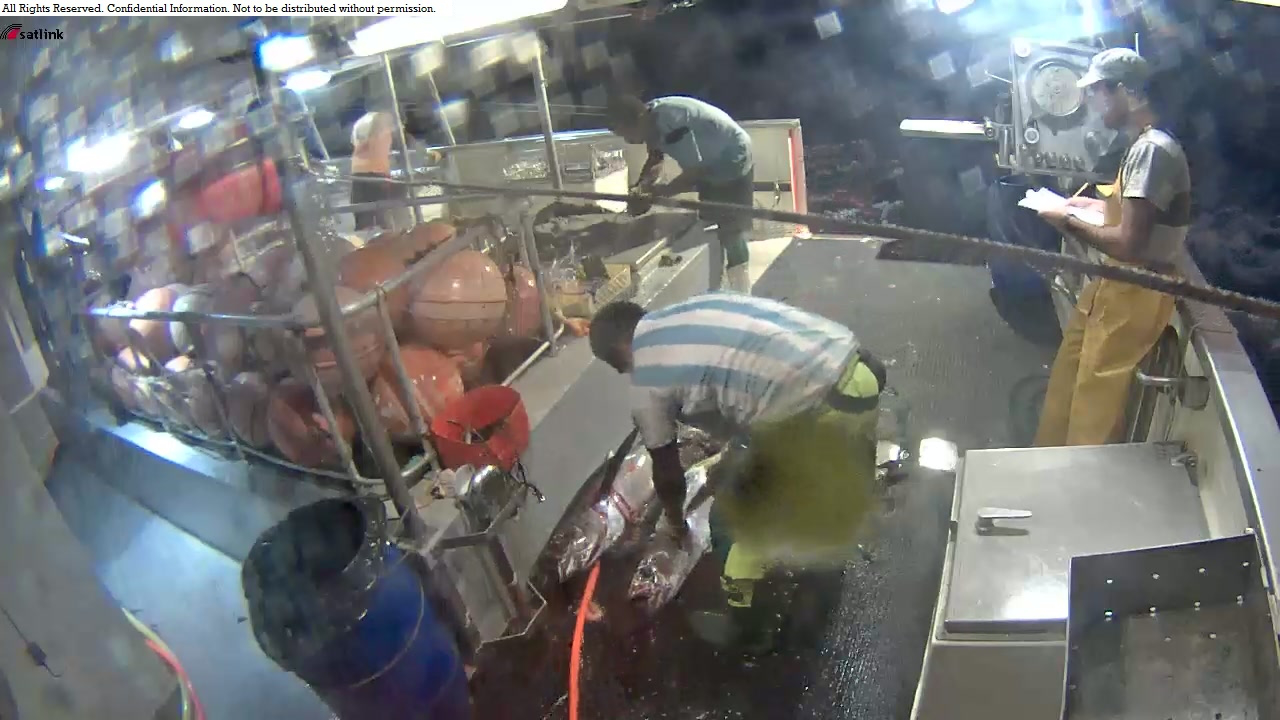

In [88]:
img = load_img(get_random_image_path(VALID_PATH))
print(img.size)
img

### Image preprocessing

### Model

In [108]:
#Linear Model
model = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Flatten(),
        Dense(8, activation='softmax', W_regularizer=l2(0.01))
    ])

In [109]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.00001), metrics=['accuracy'])

### Training

In [110]:
BATCH_SIZE = 64

In [111]:
image_generator = ImageDataGenerator()
train_generator = image_generator.flow_from_directory(
        TRAIN_PATH,  # this is the target directory
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='categorical')  # multiclass categorization

valid_generator = image_generator.flow_from_directory(
        VALID_PATH,
        target_size=(224, 224),
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')

Found 3022 images belonging to 8 classes.
Found 755 images belonging to 8 classes.


In [112]:
model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.nb_sample,
        nb_epoch=1,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'first_try.h5')

Epoch 1/1
3022/3022 [==============================] - 59s - loss: 1.5849 - acc: 0.5374 - val_loss: 1.1829 - val_acc: 0.6887

In [113]:
#model.optimizer.lr = 0.0001
model.fit_generator(
        train_generator,
        samples_per_epoch=train_generator.nb_sample,
        nb_epoch=4,
        validation_data=valid_generator,
        nb_val_samples=valid_generator.nb_sample)
model.save_weights(WEIGHTS_PATH+'second_try.h5')

Epoch 1/4
3022/3022 [==============================] - 58s - loss: 0.9805 - acc: 0.7459 - val_loss: 0.8583 - val_acc: 0.7775

In [115]:
model.load_weights(WEIGHTS_PATH+'second_try.h5')

### Predict

In [116]:
#NEED TO MAKE THE UNKNOWN DIR
image_generator = ImageDataGenerator()
test_images = image_generator.flow_from_directory(
        TEST_PATH,
        shuffle=False,
        target_size=(224,224),  # all images will be resized to 224x224
        batch_size=BATCH_SIZE*2,
        class_mode='categorical')  # multiclass categorization

Found 1000 images belonging to 1 classes.


In [117]:
preds = model.predict_generator(test_images, val_samples=test_images.nb_sample)

In [118]:
clipped_preds = preds.clip(.03,.97)

### Submit

In [119]:
def get_filenames():
    filenames = []
    for f in test_images.filenames:
        filenames.append(f[f.find("/")+1:])
    return filenames
test_filenames = get_filenames()
print (test_filenames[:3])

['img_02993.jpg', 'img_04263.jpg', 'img_00551.jpg']


In [120]:
submission = pd.DataFrame(clipped_preds, columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])
submission.insert(0, 'image', test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_02993.jpg,0.071766,0.03000,0.069236,0.03,0.057114,0.053672,0.03000,0.716309
1,img_04263.jpg,0.970000,0.03000,0.030000,0.03,0.030000,0.030000,0.03000,0.030000
2,img_00551.jpg,0.847669,0.03000,0.030000,0.03,0.048534,0.043096,0.03000,0.030000
3,img_04479.jpg,0.100086,0.03000,0.030000,0.03,0.030000,0.698356,0.03626,0.117570
4,img_01392.jpg,0.030000,0.52193,0.030000,0.03,0.030000,0.030000,0.03000,0.444585


In [121]:
submit_file_path = RESULTS_PATH+'submissions.csv'
submission.to_csv(submit_file_path, index=False)

In [122]:
FileLink(submit_file_path)

/home/bfortuner/workplace/data/fisheries/results/submissions.csv